<a href="https://colab.research.google.com/github/mohamedxxhechxxbenxxhadid/tactic_sense/blob/oumaima/BO4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

# Décompression uniquement d'EmoDB (on ignore RAVDESS.zip.zip)
emodb_zip_path = "/content/EmoDB.zip"
emodb_extract_path = "/content/data/EmoDB"

# Vérifie que le fichier existe
if os.path.exists(emodb_zip_path):
    with zipfile.ZipFile(emodb_zip_path, 'r') as zip_ref:
        zip_ref.extractall(emodb_extract_path)
    print("✅ EmoDB a été extrait avec succès.")
else:
    print("❌ Le fichier EmoDB.zip n'existe pas à ce chemin :", emodb_zip_path)

# Compter les fichiers audio extraits
for root, dirs, files in os.walk("/content/data"):
    print(f"{root} : {len(files)} fichier(s)")


✅ EmoDB a été extrait avec succès.
/content/data : 0 fichier(s)
/content/data/EmoDB : 0 fichier(s)
/content/data/EmoDB/wav : 535 fichier(s)
/content/data/RAVDESS.zip : 0 fichier(s)


In [ ]:
import os
import zipfile

# Chemins vers les fichiers ZIP
emodb_zip_path = "/content/EmoDB.zip"
ravdess_zip_path = "/content/RAVDESS.zip.zip"  # corriger ce nom si besoin

# Dossiers de destination
emodb_extract_path = "/content/data/EmoDB"
ravdess_extract_path = "/content/data/RAVDESS"

# Fonction de décompression avec vérification
def extract_zip(zip_path, extract_to, label):
    if os.path.exists(zip_path):
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"✅ {label} a été extrait avec succès.")
        except zipfile.BadZipFile:
            print(f"❌ Le fichier {label} est corrompu ou n'est pas un fichier ZIP valide.")
    else:
        print(f"❌ Le fichier {label} est introuvable à l'emplacement : {zip_path}")

# Extraire les deux jeux de données
extract_zip(emodb_zip_path, emodb_extract_path, "EmoDB")
extract_zip(ravdess_zip_path, ravdess_extract_path, "RAVDESS")

# Afficher le nombre de fichiers audio extraits
print("\n📁 Nombre de fichiers extraits par dossier :")
for root, dirs, files in os.walk("/content/data"):
    print(f"{root} : {len(files)} fichier(s)")


✅ EmoDB a été extrait avec succès.
✅ RAVDESS a été extrait avec succès.

📁 Nombre de fichiers extraits par dossier :
/content/data : 0 fichier(s)
/content/data/EmoDB : 0 fichier(s)
/content/data/EmoDB/wav : 535 fichier(s)
/content/data/RAVDESS : 0 fichier(s)
/content/data/RAVDESS/RAVDESS.zip : 0 fichier(s)
/content/data/RAVDESS.zip : 0 fichier(s)


(CRISP-DM) : Data Understanding

Objectif :

Charger, visualiser et comprendre les fichiers audio (format, durée, étiquettes), et convertir les signaux en mel-spectrogrammes, comme dans le papier.



1. Lister les fichiers WAV

In [ ]:
import glob

emodb_files = glob.glob("/content/data/EmoDB/**/*.wav", recursive=True)
ravdess_files = glob.glob("/content/data/RAVDESS/**/*.wav", recursive=True)

print(f"📦 EmoDB : {len(emodb_files)} fichiers audio")
print(f"📦 RAVDESS : {len(ravdess_files)} fichiers audio")


📦 EmoDB : 535 fichiers audio
📦 RAVDESS : 0 fichiers audio


2. Charger et écouter un échantillon

Durée : 1.60 secondes — Fréquence d'échantillonnage : 22025 Hz


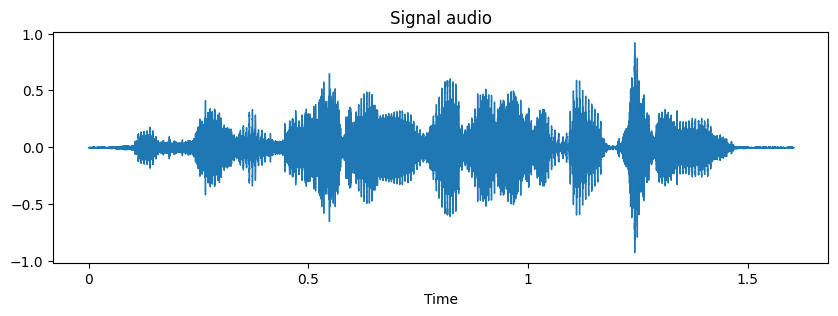

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Charger un fichier WAV
sample_path = emodb_files[0]  # ou ravdess_files[0]
y, sr = librosa.load(sample_path, sr=22025)

print(f"Durée : {len(y)/sr:.2f} secondes — Fréquence d'échantillonnage : {sr} Hz")

# Visualiser l'onde audio
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Signal audio")
plt.show()


3. Convertir en mel-spectrogramme

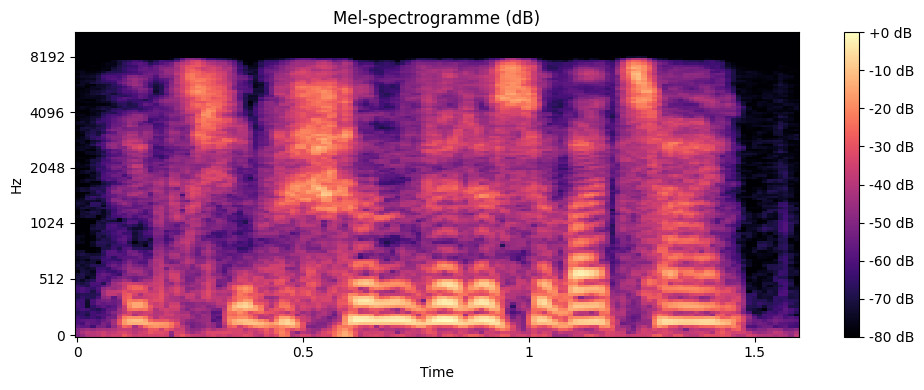

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np  # 🔥 à ne pas oublier !

# Charger un fichier audio
sample_path = emodb_files[0]  # ou ravdess_files[0]
y, sr = librosa.load(sample_path, sr=22025)

# Calcul du mel-spectrogramme
n_fft = 1024
hop_length = 256
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
mel_db = librosa.power_to_db(mel, ref=np.max)

# Affichage du spectrogramme
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.f dB")
plt.title("Mel-spectrogramme (dB)")
plt.tight_layout()
plt.show()


CRISP-DM: Data Preparation

Convertir tous les fichiers .wav (EmoDB + RAVDESS) en mel-spectrogrammes

Normaliser et appliquer du padding à 10 secondes (comme dans l’article)

Associer chaque spectrogramme à un label (émotion)

 Étape : Génération de X (features) et y (labels)texte en gras

1. Définir les émotions (labels)

In [ ]:
# Liste des émotions utilisées dans l'article (EmoDB + RAVDESS)
emotion_labels = {
    'W': 'Anger',
    'L': 'Boredom',
    'E': 'Disgust',
    'A': 'Fear',
    'F': 'Happy',
    'T': 'Sadness',
    'N': 'Neutral'
}


2. Fonction de prétraitement WAV → mel-spectrogramme

In [ ]:
def process_audio_to_mel(path, target_sr=22025, duration=10.0, n_fft=1024, hop_length=256):
    y, sr = librosa.load(path, sr=target_sr)
    if len(y) < int(duration * sr):
        y = np.pad(y, (0, int(duration * sr) - len(y)))
    else:
        y = y[:int(duration * sr)]

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db


3. Extraire tous les spectrogrammes + labels

In [ ]:
X = []
y = []

# Parcours EmoDB
for file_path in emodb_files:
    filename = os.path.basename(file_path)
    emotion_code = filename[5]  # ex: '03a01**W**a.wav'
    if emotion_code in emotion_labels:
        label = emotion_labels[emotion_code]
        mel = process_audio_to_mel(file_path)
        X.append(mel)
        y.append(label)


 4. Vérification rapide

Nombre total d'exemples : 535
Étiquettes uniques : {'Sadness', 'Happy', 'Anger', 'Boredom', 'Neutral', 'Disgust', 'Fear'}


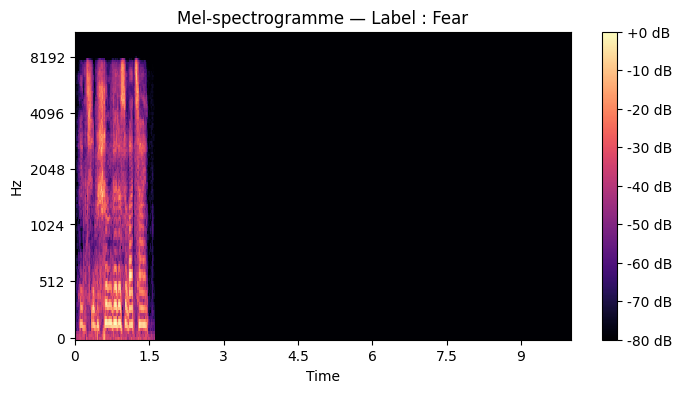

In [ ]:
print(f"Nombre total d'exemples : {len(X)}")
print("Étiquettes uniques :", set(y))

# Exemple visuel
plt.figure(figsize=(8, 4))
librosa.display.specshow(X[0], x_axis='time', y_axis='mel', sr=22025, hop_length=256)
plt.title(f"Mel-spectrogramme — Label : {y[0]}")
plt.colorbar(format='%+2.0f dB')
plt.show()


1. Dictionnaire de mapping

In [ ]:
ravdess_emotion_map = {
    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Happy',
    '04': 'Sad',
    '05': 'Angry',
    '06': 'Fearful',
    '07': 'Disgust',
    '08': 'Surprised'
}


 2. Extraire et convertir RAVDESS

In [ ]:
# Initialisation
X_ravdess = []
y_ravdess = []

# Traitement
for file_path in ravdess_files:
    filename = os.path.basename(file_path)
    try:
        emotion_id = filename.split('-')[2]  # ex: '03-01-05-01-01-01-01.wav' → '05'
        if emotion_id in ravdess_emotion_map:
            label = ravdess_emotion_map[emotion_id]
            mel = process_audio_to_mel(file_path)
            X_ravdess.append(mel)
            y_ravdess.append(label)
    except Exception as e:
        print(f"Erreur fichier {filename} : {e}")


3. Fusionner EmoDB + RAVDESS (optionnel)

In [ ]:
X_total = X + X_ravdess
y_total = y + y_ravdess

print(f"✅ Total d'exemples : {len(X_total)}")
print("Émotions présentes :", set(y_total))


✅ Total d'exemples : 535
Émotions présentes : {'Sadness', 'Happy', 'Anger', 'Boredom', 'Neutral', 'Disgust', 'Fear'}


 Étape CRISP-DM : Modeling

Objectif :

Entraîner un modèle de classification d’émotions à partir de mel-spectrogrammes.

 1. Convertir X et y en tenseurs PyTorch

Avant d’entraîner un ResNet, on doit :

transformer les spectrogrammes en images 2D (ajouter une dimension channel),

encoder les labels en entiers (classification),

normaliser les données.

In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Convertir en tableaux numpy et ajouter le channel
X_np = np.array([x for x in X_total])
X_np = X_np[:, np.newaxis, :, :]  # (N, 1, H, W)

# Encoder les labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_total)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_np, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Convertir en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


2. Préparer les DataLoader

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


 3. Définir un modèle ResNet18 adapté (1 canal)

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Charger ResNet18
resnet = models.resnet18(pretrained=False)

# Adapter le premier layer pour 1 canal (au lieu de 3)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Adapter la couche de sortie
num_classes = len(np.unique(y_encoded))
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Envoi sur GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 4. Entraîner le modèle

modèle CNN (correct et dynamique)

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)

        # On initialise le fc1 plus tard avec les bonnes dimensions
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 16, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, 32, H/4, W/4]

        if self.fc1 is None:
            # calcul dynamique du flatten
            self._to_linear = x.view(x.size(0), -1).shape[1]
            self.fc1 = nn.Linear(self._to_linear, 128).to(x.device)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
model = SmallCNN(num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


 1. 🔁 Entraîner le modèle sur quelques epochs

> Ajouter une citation



In [ ]:
import time

epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"📘 Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - ⏱ {time.time() - start_time:.2f}s")


📘 Epoch 1/10 - Loss: 6.1800 - ⏱ 45.61s
📘 Epoch 2/10 - Loss: 5.0980 - ⏱ 44.26s
📘 Epoch 3/10 - Loss: 4.1667 - ⏱ 44.47s
📘 Epoch 4/10 - Loss: 3.5702 - ⏱ 44.52s
📘 Epoch 5/10 - Loss: 3.6114 - ⏱ 43.54s
📘 Epoch 6/10 - Loss: 3.1174 - ⏱ 44.38s
📘 Epoch 7/10 - Loss: 2.9867 - ⏱ 44.65s
📘 Epoch 8/10 - Loss: 2.6860 - ⏱ 45.36s
📘 Epoch 9/10 - Loss: 2.5295 - ⏱ 43.58s
📘 Epoch 10/10 - Loss: 2.5018 - ⏱ 44.73s


2. 📈 Afficher la courbe de perte (Loss)

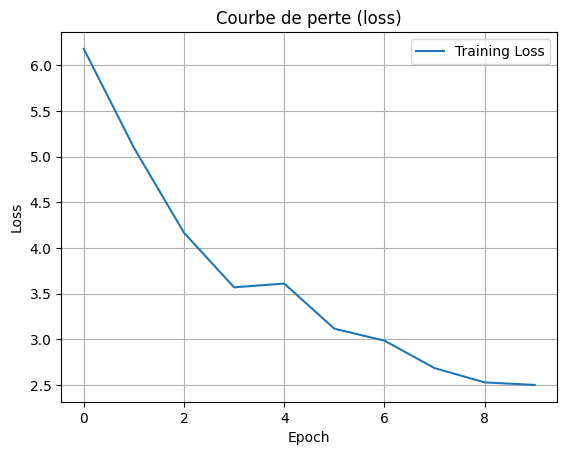

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de perte (loss)')
plt.legend()
plt.grid(True)
plt.show()


3. 📊 Afficher le rapport de classification

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())

print(classification_report(all_targets, all_preds, target_names=le.classes_))


              precision    recall  f1-score   support

       Anger       0.27      0.92      0.41        26
     Boredom       0.08      0.06      0.07        16
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00        14
       Happy       0.00      0.00      0.00        14
     Neutral       0.00      0.00      0.00        16
     Sadness       0.50      0.08      0.14        12

    accuracy                           0.24       107
   macro avg       0.12      0.15      0.09       107
weighted avg       0.13      0.24      0.13       107



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 CRISP-DM – Étape : Evaluation

Objectif : Évaluer ton modèle sur des données de test à l’aide de metrics précises :
🔸 Accuracy, Precision, Recall, F1-score
🔸 Matrice de confusion
🔸 Analyse des erreurs

 1. Rapport de classification (Sklearn)

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())

print(classification_report(all_targets, all_preds, target_names=le.classes_))


              precision    recall  f1-score   support

       Anger       0.27      0.92      0.41        26
     Boredom       0.08      0.06      0.07        16
     Disgust       0.00      0.00      0.00         9
        Fear       0.00      0.00      0.00        14
       Happy       0.00      0.00      0.00        14
     Neutral       0.00      0.00      0.00        16
     Sadness       0.50      0.08      0.14        12

    accuracy                           0.24       107
   macro avg       0.12      0.15      0.09       107
weighted avg       0.13      0.24      0.13       107



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 2. Matrice de confusion
python
Copier
Modifier


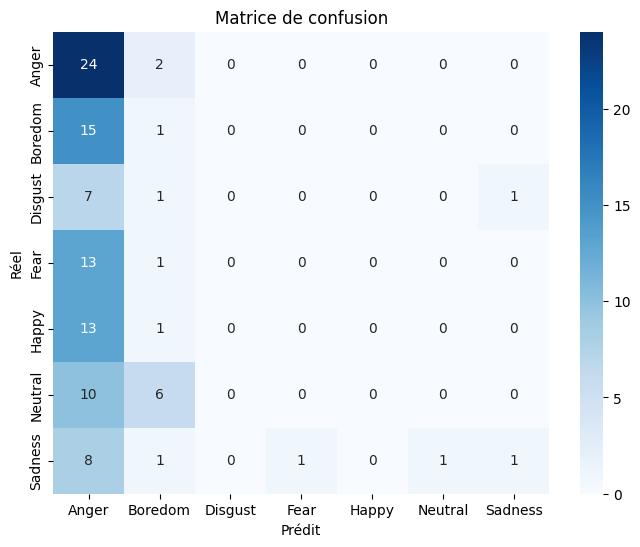

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


 3. Taux de performance global

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(all_targets, all_preds)
print(f"🎯 Accuracy globale du modèle : {acc * 100:.2f}%")


🎯 Accuracy globale du modèle : 24.30%


 Étape 1 : Définir le modèle CNN + LSTM

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        self.lstm_input_dim = 32 * 32  # H x W after pooling
        self.lstm = nn.LSTM(input_size=self.lstm_input_dim, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # CNN
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, H/4, W/4]

        # Préparer pour LSTM
        B, C, H, W = x.shape
        x = x.view(B, W, C * H)  # [B, sequence_len, features]

        # LSTM
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # dernière sortie
        out = self.fc(out)
        return out


Étape 2 : Initialisation et entraînement

In [ ]:
model = CNN_LSTM(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()


Étape suivante : Entraîner et évaluer ce nouveau modèle

1. 🔁 Boucle d'entraînement

In [ ]:
import time

epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"📘 Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - ⏱ {time.time() - start_time:.2f}s")


📘 Epoch 1/10 - Loss: 1.6032 - ⏱ 75.92s
📘 Epoch 2/10 - Loss: 1.5227 - ⏱ 67.36s
📘 Epoch 3/10 - Loss: 1.4625 - ⏱ 66.44s
📘 Epoch 4/10 - Loss: 1.4066 - ⏱ 66.40s
📘 Epoch 5/10 - Loss: 1.3408 - ⏱ 66.02s
📘 Epoch 6/10 - Loss: 1.3067 - ⏱ 67.01s
📘 Epoch 7/10 - Loss: 1.2492 - ⏱ 66.68s
📘 Epoch 8/10 - Loss: 1.2135 - ⏱ 65.97s
📘 Epoch 9/10 - Loss: 1.1708 - ⏱ 65.99s
📘 Epoch 10/10 - Loss: 1.1205 - ⏱ 73.23s


2. 📈 Affichage de la courbe de perte

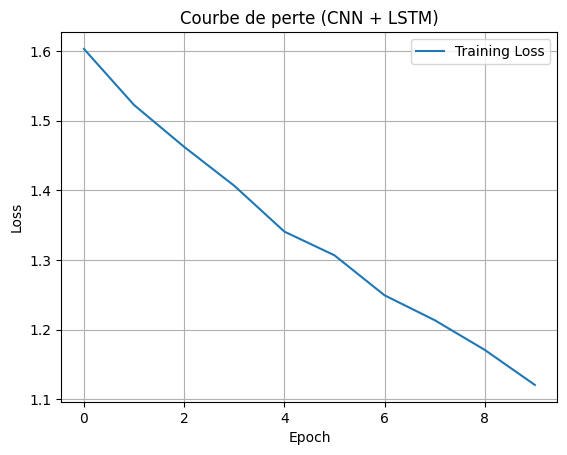

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe de perte (CNN + LSTM)')
plt.legend()
plt.grid(True)
plt.show()


3. 📊 Rapport de classification

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())

print(classification_report(all_targets, all_preds, target_names=le.classes_))


              precision    recall  f1-score   support

       Anger       0.47      0.81      0.59        26
     Boredom       0.54      0.81      0.65        16
     Disgust       0.00      0.00      0.00         9
        Fear       0.20      0.07      0.11        14
       Happy       0.38      0.36      0.37        14
     Neutral       0.64      0.44      0.52        16
     Sadness       0.56      0.42      0.48        12

    accuracy                           0.49       107
   macro avg       0.40      0.41      0.39       107
weighted avg       0.43      0.49      0.43       107



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4. 📉 Matrice de confusion

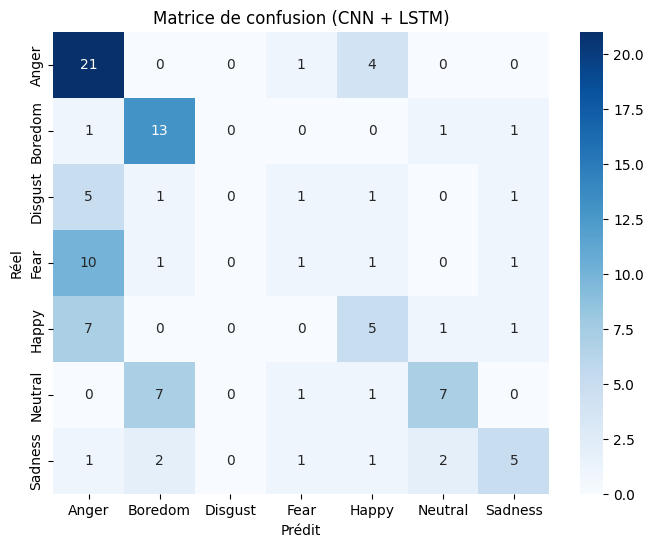

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (CNN + LSTM)")
plt.show()


afficher l’Accuracy globale

In [ ]:
from sklearn.metrics import accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(all_targets, all_preds)
print(f"🎯 Accuracy globale du modèle CNN + LSTM : {accuracy * 100:.2f}%")


🎯 Accuracy globale du modèle CNN + LSTM : 48.60%


| Modèle        | Accuracy (%) | Observations                               |
| ------------- | ------------ | ------------------------------------------ |
| 🧱 CNN simple | 24.30%       | Très déséquilibré, surprédiction "Anger"   |
| 🧠 CNN + LSTM | **48.60%**   | Meilleure balance, mais encore perfectible |
